I built this notebook primarily to include as a supplement to a resume as a semi-practical example of python skills. Given that any data science position will likely benefit from if not require skills in a data science focused programming language, I wanted a way to display that beyond simply stating I have them in a resume.

For this, I wanted a dataset that was widely available, and one I hadn't worked with before. I also wanted one with a large number of rows to try machine learning algorithms on. After briefly googling datasets, I chose to use the California housing dataset.

My goal at the outset is to develop a model to predict housing prices based on available attributes. My goal isn't necessarily to develop the best model for the job, or to determine a explanatory relationship from the attributes, but more to demonstrate creating the model

In [ ]:
# this block will install the libraries used in this notebook.
# most likely you already have most or all of these
# but I wanted to include it to ensure operability
! pip install seaborn
! pip install matplotlib
! pip install numpy
! pip install pandas
! pip install scipy
! pip install sklearn
! pip install xgboost


In [1]:
import sklearn
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor as xgb_reg
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

Scikit Learn has a function to download the dataset. I wanted to use this instead of finding and downloading the dataset myself since someone would be able to take this notebook and run it as is rather than having to seek out and find the same dataset I used and upload it into the notebook. A description of the housing dataset is available here (https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html).

One interesting note is that average rooms and average bedrooms are averaged on households in the block, not house units in the block. That could create some difficulties in using the room numbers and bedroom numbers in determining the housing value.

In [2]:
california_housing = fetch_california_housing(as_frame=True)
ch_df = california_housing.frame

In [3]:
# let's take a quick look at the data to make sure it looks right and get an idea of what's in there.
ch_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


Let's see if there's any missing data. In this case, we probably can't do anything to fill in missing values, so my plan is to remove those rows. If there are too many rows with missing data, I'll have to come up with a different plan to fix it. Potentially, we could avoid using the columns that have the missing values if the missing values are mostly in the same column, but I think that might have more of a determental impact on the model than removing the rows depending on the number of rows with missing data.

In [4]:
mv_df = ch_df[ch_df.isna().any(axis=1)]

In [5]:
mv_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal


It appears there are no rows with missing data. I don't completely trust that. There's typically missing data somewhere in datasets, especially toy datasets that seem to include challenges specifically for people to practice python skills with. Just to be sure, I'm going to test dropping data that has missing values, just to be sure.

In [6]:
print(len(ch_df))
print(len(ch_df.dropna()))

20640
20640


Since there's no difference between the the sizes of the two dataframes, I feel safe in accepting there are no null values in our data. 

I want to take a little bit better look at the data. Knowing how the data is formatted and knowing there aren't missing values is good, but we need to get an idea of what our data looks like as a whole before we try to do too much with it.

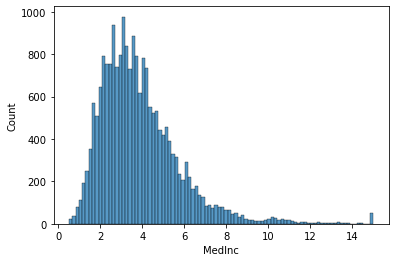

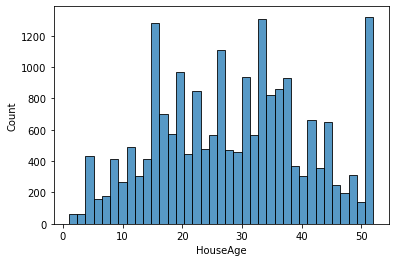

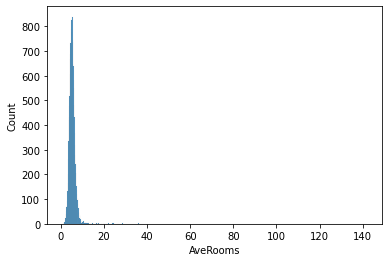

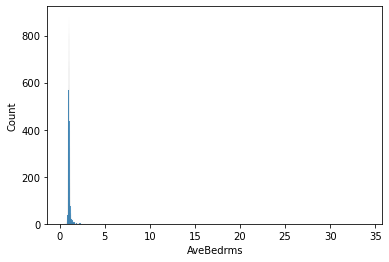

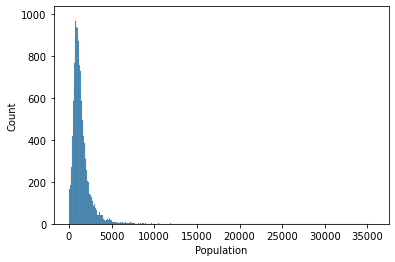

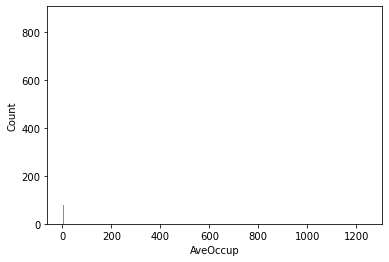

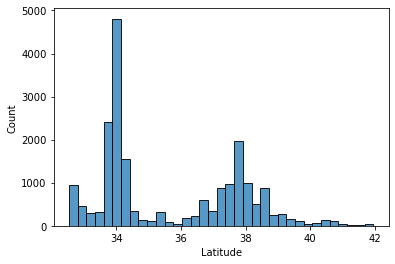

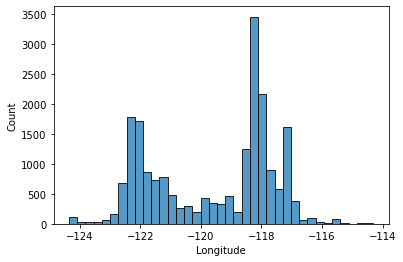

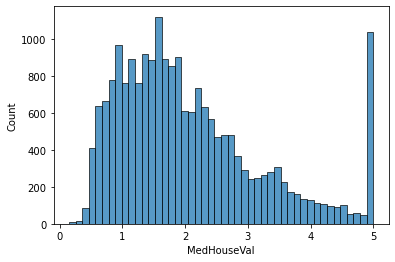

In [7]:
for column in ch_df.columns:
    sns.histplot(ch_df[column])
    plt.show()

so already we can see some problems with the data. There's an unusual spike in the high ends of median income, house age, and median house value. My suspicion is the high ends got binned into the same value, and that would certaintly create a problem for our model.

In [8]:
medinc_df = ch_df[ch_df['MedInc'] > 14.5]

<AxesSubplot:xlabel='MedInc', ylabel='Count'>

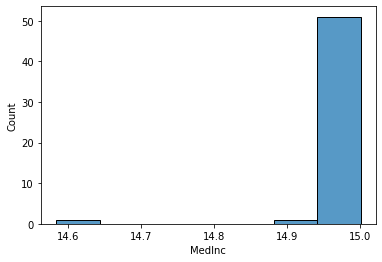

In [9]:
sns.histplot(medinc_df['MedInc'])

Yes, that's almost certainly binning of the housing data. I can't come up with a good idea of how to correct this data. We can't mix ratio and ordinal data in the same column and expect our model to perform correctly, and we can't determine what its actual value is from the information we have. I'm going to drop the max values for these columns.

In [10]:
print('max income number: {}'.format(ch_df['MedInc'].max()))
print('max house age number: {}'.format(ch_df['HouseAge'].max()))
print('max median house value number: {}'.format(ch_df['MedHouseVal'].max()))
#print('max income number: {}'.format(ch_df['MedInc'].max()))

max income number: 15.0001
max house age number: 52.0
max median house value number: 5.00001


In [11]:
chd_df = ch_df[ch_df['MedInc'] != ch_df['MedInc'].max()]
chd_df = chd_df[chd_df['HouseAge'] != ch_df['HouseAge'].max()]
chd_df = chd_df[chd_df['MedHouseVal'] != ch_df['MedHouseVal'].max()]

In [12]:
print(len(ch_df))
print(len(chd_df))

20640
18570


Well, we removed about 10% of our data. It's not great, but it's not devastating. More importantatly, our model wouldn't necessarily be reliable for predicting values over $500,000. There's the potential it could accurately do so, but we can't trust a model to make predictions outside the ranges of its training data. In traditional statistical terms, this is refered to as extrapolation, and is typically considered an error to attempt it.

Now I want to see a little more detail about our columns and check for potential collinearity. As I said, my goal isn't necessarily to develop an explanatory model, however, it would be good to note. 

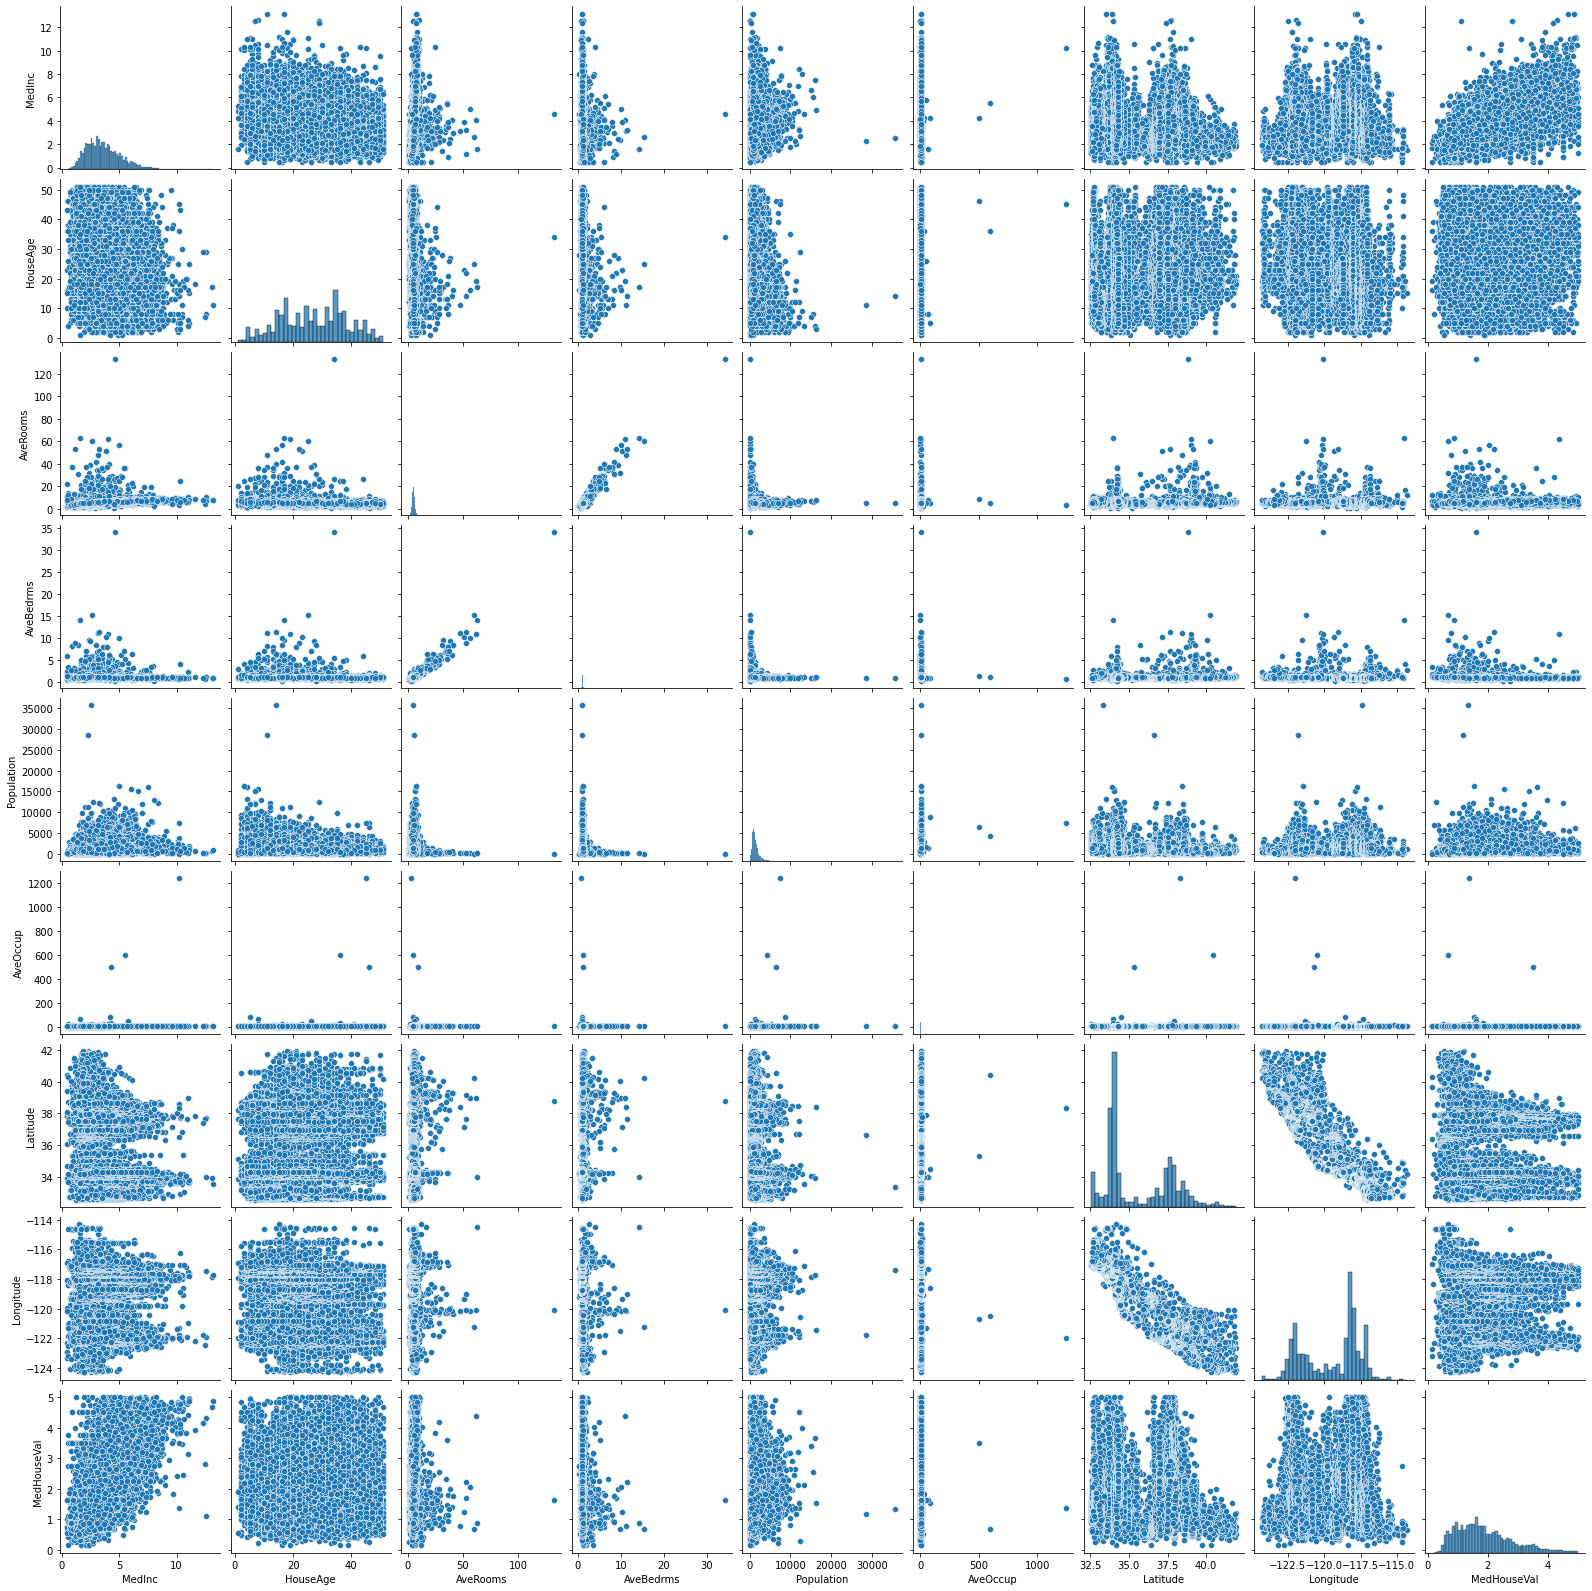

In [13]:
sns.pairplot(chd_df)

Very clearly there's a correlation with average rooms and average bedrooms which is pretty intuitive. A few other things to note, median income isn't as strongly correlated with median house value as I'd expect. It looks like there's a relationship there, but not as strong as I would have thought. It's also hard to see much in the average occupancy, probably because of a few densley populated outliers, what I'd expect to be blocks with large apartment complexes.

Ok, now on to the models. I'm starting with a random forest. I tend towards random forests for most problems. They tend to perform decently with a large variety of problems, although they tend not to usually be the best, they do well enough and are easy to set up. They also are hard to overfit, although contrary to some source documentation, it is possible to overfit them.


Since median income will be correlated to housing value, but isn't a property of the housing, I need to remove it beforehand. The model may learn to use median income of an area to determine housing prices of an area, even though housing prices are more likely to be a cause of higher income for people living in the area rather than vice versa.

In [14]:
chd_ir_df = chd_df.drop(columns = 'MedInc')

In [15]:
# breaking our data frame into our predictive and target features

features_1_df = chd_ir_df.drop(columns = 'MedHouseVal')
labels_1_df = chd_ir_df['MedHouseVal']



In [16]:
# splitting our data into training and testing data sets
x_train, x_test, y_train, y_test = train_test_split(features_1_df, labels_1_df, test_size=0.25)

In [17]:
# set model parameters
rfr = RandomForestRegressor(n_estimators=100)

In [18]:
#fit the model
rfr.fit(x_train, y_train)

RandomForestRegressor()

In [19]:
rfr_training_predictions = rfr.predict(x_train)
rfr_predictions = rfr.predict(x_test)

In [21]:
#model performance
print('random forest')

print('testing R2 : {}'.format(r2_score(y_test, rfr_predictions)))
print('testing mean squared error : {}'.format(mean_squared_error(y_test, rfr_predictions)))
print('testing mean absolute error : {}'.format(mean_absolute_error(y_test, rfr_predictions)))

random forest
testing R2 : 0.8008935891072172
testing mean squared error : 0.1869939718613834
testing mean absolute error : 0.28578549332328235


Well, it's not terrible. We're looking at an average error of about $29,000 in our predictions. I'd think in general the model would be acceptable, although real world we'd probably have an existing model to compare it to. I'd like to check a residuals plot to see if anything weird is going on with our predictions there.

<AxesSubplot:ylabel='MedHouseVal'>

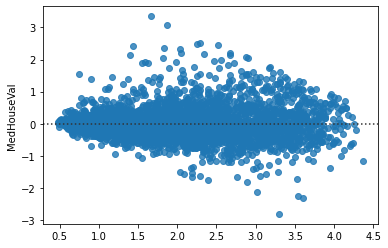

In [22]:
sns.residplot(x= rfr_predictions, y = y_test)

There are a couple things that look slightly concerning, but nothing too worrisome. There seems to be a little larger spread on top, there's almost a diagnal line forming on the top right, and it looks like we have a couple of big outliers around predictions for \\$150,000 and $330,000. That said, it doesn't look that bad. So although this isn't an all encompassing test, given the fairly decent looking residuals plot and R2 value, it looks like the model is generally performing well.

So we created what appears to be an effective model, it's a fair bit less effective than say Zillow's predictions, although they have more granular data and previous sales prices to work with. With nothing but census block data, I'm pretty happy with this model. That said, our purpose here isn't so much to make predictions or explanations, as it is to go through the process of building a model. I want to see if we can make this better, or possibly find a better type of algorithm to use.

*********
A note, I don't recommend running the next 3 code blocks. There are 5,5,4, and 8 different parameters in our grid giving 800 combinations, and grid search will run 5 folds by default for each set of parameters. The below code will train 4,000 models. It will take a long time to run. I set it to run right before I went to bed and let it run overnight. Although I lost the original run, I still have the selected parameters from it.

In [ ]:

parameters = {'n_estimators':[20,60,100,150,200],
             'max_depth': [x for x in range(4,21,4)],
             'min_samples_leaf': [x for x in range(1,8,2)],
             'max_features': [x for x in range(1,8)]}

#parameters = {'n_estimators':[20,40]}


rfr_grid = GridSearchCV(rfr, parameters,n_jobs = 6, return_train_score=True)

In [ ]:
#please note, this will take a long time to run
rfr_grid.fit(x_train, y_train)

In [ ]:
print(rfr_grid.best_params_) 

It looks like we have our parameters for our model. I'm a little hesitant about the max depth and n estimators, since those were the max values of our grid. It could just be that the model is steadily improving as those values increase and we haven't squeezed the most out of the algorithm yet. But as I said, we really aren't trying to make the best model exactly, so we'll go with these values and see what happens. Also as an aside, it was important for us to use the grid search on our testing data only. It's a little odd, but we might overfit our model parameters to our data if we used all of our data for tuning our model.

In [23]:
rfr_tuned = RandomForestRegressor(n_estimators=200, max_depth = 20, max_features = 5, min_samples_leaf = 1)
rfr_tuned.fit(x_train, y_train)
rfr_t_training_predictions = rfr_tuned.predict(x_train)
rfr_t_predictions = rfr_tuned.predict(x_test)

In [24]:
print('testing R2 : {}'.format(r2_score(y_test, rfr_t_predictions)))
print('testing mean squared error : {}'.format(mean_squared_error(y_test, rfr_t_predictions)))
print('testing mean absolute error : {}'.format(mean_absolute_error(y_test, rfr_t_predictions)))

testing R2 : 0.803170953712552
testing mean squared error : 0.1848551484502306
testing mean absolute error : 0.284669126225657


<AxesSubplot:ylabel='MedHouseVal'>

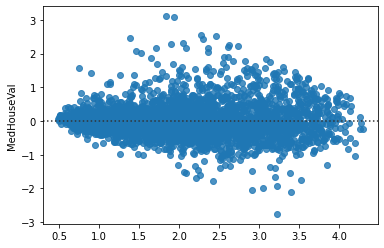

In [25]:
sns.residplot(x= rfr_t_predictions, y = y_test)

Well, tuning our model didn't really give us much gain. It's a little amusing to me that the model with its default parameters performed about the same as one tuned with a grid search. All that time put into the grid search didn't really do much for us in this case. Speaking of that, even using 6 cores, that grid search took way too long for my liking. I'm thinking we should try to do better.

In [26]:
xgbr = xgb_reg(tree_method = 'gpu_hist')

In [27]:
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [28]:
xgbr_training_predictions = xgbr.predict(x_train)
xgbr_predictions = xgbr.predict(x_test)

In [29]:
print('testing R2 : {}'.format(r2_score(y_test, xgbr_predictions)))
print('testing mean squared error : {}'.format(mean_squared_error(y_test, xgbr_predictions)))
print('testing mean absolute error : {}'.format(mean_absolute_error(y_test, xgbr_predictions)))

testing R2 : 0.79923777310385
testing mean squared error : 0.1885490579570692
testing mean absolute error : 0.29084667554619237


Ok so our XGBoost regressor didn't really perform better than the random forest regressor, although I want to try tuning it in a second, but let's see how it compares speed wise.

In [30]:
%timeit rfr_tuned.fit(x_train, y_train)

7.36 s ± 63.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
# setting the same number of trees to make it a fair test
xgbr = xgb_reg(n_estimators = 200,
               tree_method = 'gpu_hist')

In [32]:
%timeit xgbr.fit(x_train, y_train)

473 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ok, so it's running about 15 times faster than our random forest. I was hoping for a little more performance, but it's still nice to get that speed boost. Let's try tuning our xgb regressor a little.

In [ ]:
parameters = {'n_estimators':[100,150,200,250],
              'sampling_method':['uniform','gradient_based'],
             'max_depth': [x for x in range(5,26,10)],
             'alpha': [.01,.1,1],
             'tree_method': ['gpu_hist']}

In [ ]:
xgbr_grid = GridSearchCV(xgbr, parameters, return_train_score=True)
xgbr_grid.fit(x_train, y_train)

In [ ]:
print(xgbr_grid.best_params_) 

That still took much longer than I'd like (I suspect there's some overhead in gridsearchcv that's not immediately apparent), but let's see what our tuned model might do.

In [33]:
xgbr = xgb_reg(alpha = 1, max_depth = 5, n_estimators = 200, sampling_method = 'uniform', tree_method = 'gpu_hist')
xgbr.fit(x_train, y_train)

XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [34]:
xgbr_training_predictions = xgbr.predict(x_train)
xgbr_predictions = xgbr.predict(x_test)

In [35]:
print('testing R2 : {}'.format(r2_score(y_test, xgbr_predictions)))
print('testing mean squared error : {}'.format(mean_squared_error(y_test, xgbr_predictions)))
print('testing mean absolute error : {}'.format(mean_absolute_error(y_test, xgbr_predictions)))

testing R2 : 0.8062863632022848
testing mean squared error : 0.18192926177562488
testing mean absolute error : 0.2900960928218641


We got a little bit better perfomance, but it's negligible. I'm dissappointed, but also surprised that the random forest and xgboost numbers are so similar. They're both ensemble methods using trees, so that might explain it, but I'm still surprised.

In [36]:
hidden_layers = [[10,8,6,4,2],[25,20,10,5],[30],[5,5,5,5,5],[15,10,5]]

In [37]:
parameters = {'mlpregressor__hidden_layer_sizes': hidden_layers,
             'mlpregressor__activation':['relu','tanh','logistic'],
             'mlpregressor__alpha':[.0001,.001,.01,.1,1,10],
             'mlpregressor__learning_rate':['constant','adaptive'],
             'mlpregressor__max_iter':[350]}

In [38]:
pipe_line = make_pipeline(StandardScaler(),
                         MLPRegressor())

In [39]:
search = GridSearchCV(pipe_line, parameters, n_jobs=4)
search.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('mlpregressor', MLPRegressor())]),
             n_jobs=4,
             param_grid={'mlpregressor__activation': ['relu', 'tanh',
                                                      'logistic'],
                         'mlpregressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                 10],
                         'mlpregressor__hidden_layer_sizes': [[10, 8, 6, 4, 2],
                                                              [25, 20, 10, 5],
                                                              [30],
                                                              [5, 5, 5, 5, 5],
                                                              [15, 10, 5]],
                         'mlpregressor__learning_rate': ['constant',
                                                         'adaptive'],
                         'mlpregres

In [40]:
print(search.best_params_)

{'mlpregressor__activation': 'tanh', 'mlpregressor__alpha': 0.01, 'mlpregressor__hidden_layer_sizes': [25, 20, 10, 5], 'mlpregressor__learning_rate': 'constant', 'mlpregressor__max_iter': 350}


In [41]:
tuned_mlpr = MLPRegressor(activation = 'tanh',
                         alpha = 0.01,
                         hidden_layer_sizes = [25,20,10,5],
                         max_iter = 350)

In [42]:
mlp_regr = make_pipeline(StandardScaler(),
                         tuned_mlpr)

In [43]:
mlp_regr.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='tanh', alpha=0.01,
                              hidden_layer_sizes=[25, 20, 10, 5],
                              max_iter=350))])

In [44]:
mlp_regr_preds = mlp_regr.predict(x_test)

In [45]:
print('testing R2 : {}'.format(r2_score(y_test, mlp_regr_preds)))
print('testing mean squared error : {}'.format(mean_squared_error(y_test, mlp_regr_preds)))
print('testing mean absolute error : {}'.format(mean_absolute_error(y_test, mlp_regr_preds)))

testing R2 : 0.7434795108856243
testing mean squared error : 0.24091532215480574
testing mean absolute error : 0.3366537289394454


<AxesSubplot:ylabel='MedHouseVal'>

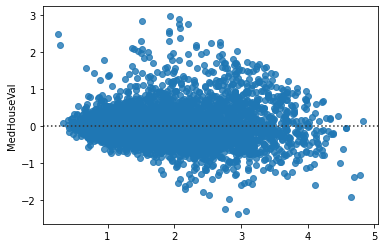

In [46]:
sns.residplot(x= mlp_regr_preds, y = y_test)

The multilayer perceptron gave worse results than our ensemble models. It's very surprising that the residual plot has such a similar shape to the other modelse except there are a few extra outliers, which is probably where the worse performance comes from.